In [1]:
import pandas as pd
import geopandas as gpd

In [19]:
raw = pd.read_csv('hospital_facility.csv', encoding='utf-8')

In [20]:
raw.columns

Index(['hospital_pk', 'collection_week', 'hospital_name', 'address', 'city',
       'zip', 'hospital_subtype', 'fips_code',
       'all_adult_hospital_inpatient_beds_7_day_avg',
       'inpatient_beds_used_7_day_avg', 'total_icu_beds_7_day_avg',
       'icu_beds_used_7_day_avg',
       'total_adult_patients_hospitalized_confirmed_covid_7_day_avg', 'lat',
       'lon'],
      dtype='object')

In [21]:
uniqLocations = raw[['lat','lon','hospital_pk', 'hospital_name', 'address', 'city',
       'zip', 'hospital_subtype', 'fips_code']].drop_duplicates()
uniqLocations = uniqLocations[uniqLocations['lat'].notnull()]

In [22]:
uniqLocations.to_csv('unique_hospitals.csv')

In [23]:
gdf = gpd.GeoDataFrame(
    uniqLocations, geometry=gpd.points_from_xy(uniqLocations.lon, uniqLocations.lat))

<AxesSubplot:>

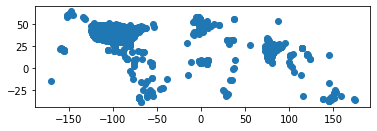

In [68]:
gdf.plot()

In [92]:
gdf_clean = gdf[gdf.hospital_pk.isin(list(beds['hospital_pk'].unique()))]

In [105]:
joinDf = gdf_clean.reset_index()[['index','hospital_pk']]
joinDf.columns = ['fid', 'hospital_pk']

In [106]:
gdf_clean.merge(joinDf, on='hospital_pk')[['geometry','fid', 'address', 'city',
       'zip', 'hospital_subtype', 'fips_code']].to_file('hospitals.geojson', driver="GeoJSON")

In [99]:
gdf_clean[['geometry','hospital_pk', 'address', 'city',
       'zip', 'hospital_subtype', 'fips_code']].to_file('hospitals.geojson', driver="GeoJSON")

In [107]:
raw = raw.merge(joinDf, how="right", on="hospital_pk")

In [108]:
beds = raw[['fid','collection_week','all_adult_hospital_inpatient_beds_7_day_avg']]
bedsUsed = raw[['fid','collection_week','inpatient_beds_used_7_day_avg']]
icuBeds = raw[['fid','collection_week','total_icu_beds_7_day_avg']]
icuBedsUsed = raw[['fid','collection_week','icu_beds_used_7_day_avg']]
totalCases = raw[['fid','collection_week','total_adult_patients_hospitalized_confirmed_covid_7_day_avg']]

In [111]:
def transposeDf(df):
    # thanks to @piRSquared on stackoverflow for this nifty pivot expressions
    # https://stackoverflow.com/questions/54915215/expressing-time-series-data-in-the-columns-rather-than-the-rows-of-a-dataframe
    df = df.pivot_table(index='fid', columns='collection_week').swaplevel(0, 1, 1).sort_index(1).reset_index()
    df.columns = [column[0] for column in list(df.columns)]
    df = df.replace(-999999.0, '')
    return df

In [112]:

transposeDf(beds).to_csv('./hospital_beds.csv', index=False)
transposeDf(bedsUsed).to_csv('./hospital_beds_used.csv', index=False)
transposeDf(icuBeds).to_csv('./hospital_icu_beds.csv', index=False)
transposeDf(icuBedsUsed).to_csv('./hospital_icu_beds_used.csv', index=False)
transposeDf(totalCases).to_csv('./hospital_cases.csv', index=False)

In [84]:
transposeDf(beds)['hospital_pk']

0                                                  010001
1                                                  010005
2                                                  010006
3                                                  010007
4                                                  010008
                              ...                        
4912    ee04edd185865c38c839812cb2eb5ae5d3f8922e3b629e...
4913                 f59a354d-92b9-409e-81d3-bef8716d9a79
4914    f70d7abf93c78280583ac18e896e6737cca8212b017513...
4915    fa96db24d19f83993a2925454eafc6fa17dd8e64270534...
4916    ff9032c172057190bf52f523d253c79af2d5f74d007084...
Name: hospital_pk, Length: 4917, dtype: object